### Import Libaries

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid



### Set-Up Device-Agnosti code

In [47]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


### Hyper-Parameters

In [48]:
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001

### Import Data

In [49]:
train_dataset=datasets.FashionMNIST(root="data/",train=True,transform=transforms.ToTensor(),download=True)
test_dataset=datasets.FashionMNIST(root="data/",train=False,transform=transforms.ToTensor())

In [50]:
# Converting Data to DataLoader
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [51]:
img_batch, label_batch = next(iter(train_dataloader))
img_batch.shape , label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [52]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

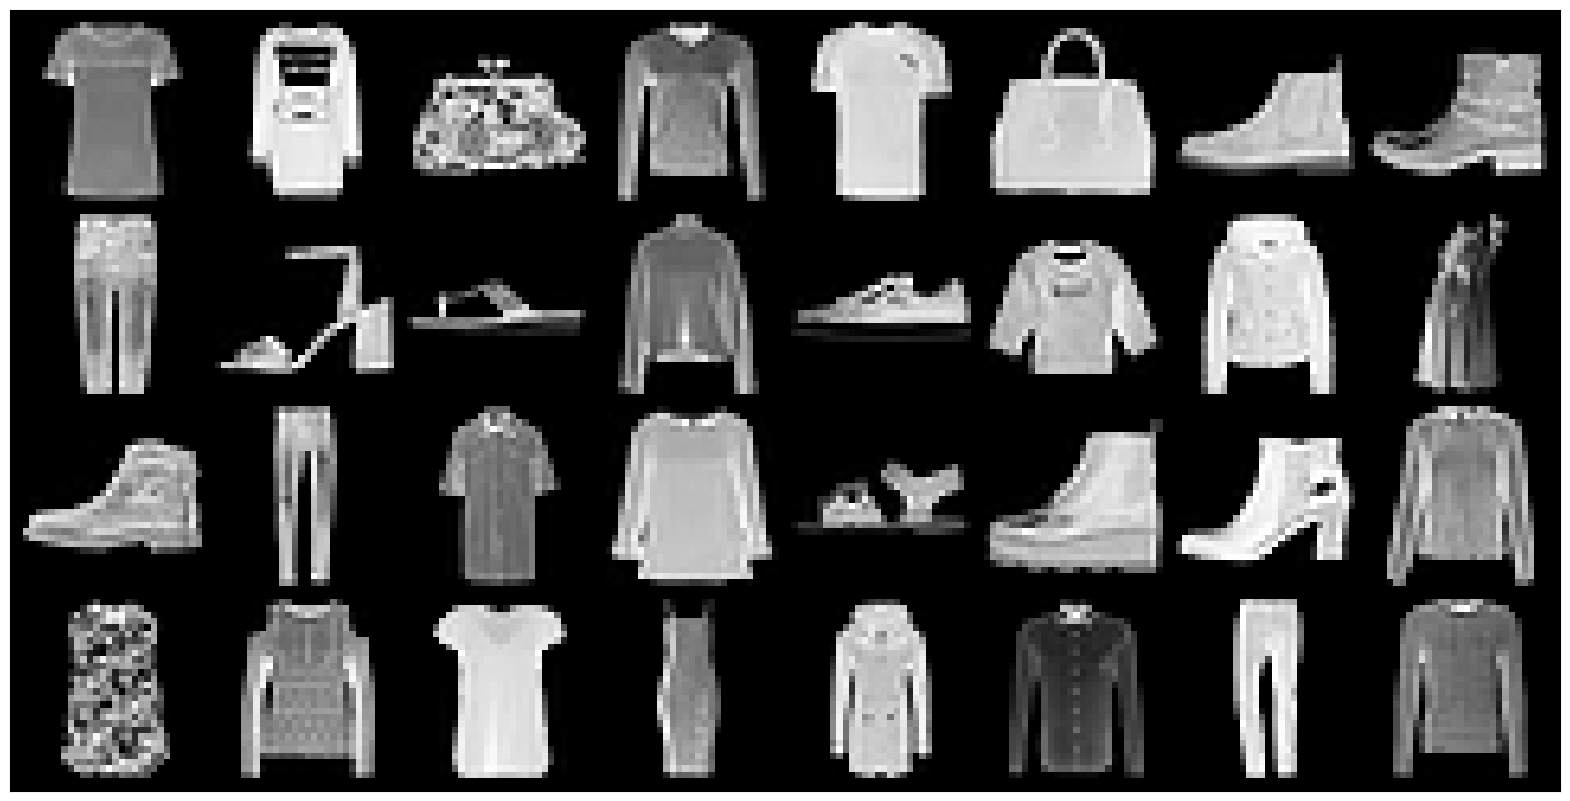

In [53]:
# Images for first batch of training
show_batch(train_dataloader)

### Creating Feed-Forward_Neural_Network Model

In [54]:
class ANN(nn.Module):
  def __init__(self,input_size, hidden_size, num_classes):
    super(ANN,self).__init__()

    self.dense1=nn.Linear(input_size,hidden_size)
    self.dense2=nn.Linear(hidden_size,hidden_size)
    self.output=nn.Linear(hidden_size,num_classes)
    self.relu=nn.ReLU()

  def forward(self,x):
    x=x.reshape(-1,784)
    x=self.dense1(x)
    x=self.relu(x)
    x=self.dense2(x)
    x=self.relu(x)
    x=self.dense2(x)
    x=self.relu(x)
    x=self.output(x)
    return x

model = ANN(input_size, hidden_size, num_classes).to(device)


In [55]:
# Get information about model
try:
  import torchinfo
except:
  !pip install torchinfo

import torchinfo
from torchinfo import summary

summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ANN                                      [1, 10]                   --
├─Linear: 1-1                            [1, 500]                  392,500
├─ReLU: 1-2                              [1, 500]                  --
├─Linear: 1-3                            [1, 500]                  250,500
├─ReLU: 1-4                              [1, 500]                  --
├─Linear: 1-5                            [1, 500]                  (recursive)
├─ReLU: 1-6                              [1, 500]                  --
├─Linear: 1-7                            [1, 10]                   5,010
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
Total mult-adds (M): 0.90
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.59
Estimated Total Size (MB): 2.61

### Define Loss function and Optimizer

In [56]:
loss_fxn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),learning_rate)

In [57]:
# Cal. Accuracy
def accuracy(y_true,y_preds):
  correct=torch.eq(y_true,y_preds).sum().item()
  acc=(correct/len(y_preds))*100
  return acc

### Train the Model

In [58]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model
total_step = len(train_dataloader)
for epoch in range(num_epochs):
    for batch, (images, labels) in enumerate(train_dataloader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fxn(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, batch+1, total_step, loss.item()))



Epoch [1/10], Step [500/1875], Loss: 0.5462
Epoch [1/10], Step [1000/1875], Loss: 0.5873
Epoch [1/10], Step [1500/1875], Loss: 0.4200
Epoch [2/10], Step [500/1875], Loss: 0.2703
Epoch [2/10], Step [1000/1875], Loss: 0.5190
Epoch [2/10], Step [1500/1875], Loss: 0.5468
Epoch [3/10], Step [500/1875], Loss: 0.1579
Epoch [3/10], Step [1000/1875], Loss: 0.3693
Epoch [3/10], Step [1500/1875], Loss: 0.3040
Epoch [4/10], Step [500/1875], Loss: 0.2449
Epoch [4/10], Step [1000/1875], Loss: 0.2130
Epoch [4/10], Step [1500/1875], Loss: 0.1861
Epoch [5/10], Step [500/1875], Loss: 0.1737
Epoch [5/10], Step [1000/1875], Loss: 0.2588
Epoch [5/10], Step [1500/1875], Loss: 0.2547
Epoch [6/10], Step [500/1875], Loss: 0.3320
Epoch [6/10], Step [1000/1875], Loss: 0.2903
Epoch [6/10], Step [1500/1875], Loss: 0.1737
Epoch [7/10], Step [500/1875], Loss: 0.4165
Epoch [7/10], Step [1000/1875], Loss: 0.2298
Epoch [7/10], Step [1500/1875], Loss: 0.3307
Epoch [8/10], Step [500/1875], Loss: 0.0807
Epoch [8/10], Step

### Test the model

In [59]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


Accuracy of the network on the 10000 test images: 88.22 %


### Save Model

In [60]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')